In [1]:
!pip install astro-datasets numpy matplotlib albumentations

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb

2022-11-20 18:37:14.409591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'Nbody_IllustrisTNG', 'field': 'Mtot', 
                                                 'parameters': ['omegam']})

2022-11-20 18:37:17.319861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 18:37:19.680270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78935 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'Nbody_SIMBA', 'field': 'Mtot', 
                                                 'parameters': ['omegam']})

In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_train = simba_train.repeat(count=3) # increase dataset size
simba_train = simba_train.map(process_data)
simba_train = simba_train.map(set_shapes)
simba_train = simba_train.map(normalize)
simba_train = simba_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_val = simba_val.map(normalize)
simba_val = simba_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
#design CNN architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64*H),
  tf.keras.layers.LeakyReLU(0.2), 
  tf.keras.layers.Dropout(0.2),  
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 14)      140       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 14)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 14)      1778      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 14)     56        
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 14)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 14)      798       
                                                        

In [11]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [12]:
#compile model, set the optimiser and the loss as defined above 
model.compile(optimizer=opt,
              loss='mae',
              metrics=['mse'])

In [13]:
epochs = 50

In [14]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

model.fit(simba_train, epochs=epochs, 
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True), reduce_lr, cp_callback], 
          validation_data=simba_val)

Epoch 1/50


2022-11-20 18:37:26.290965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-20 18:37:28.348446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-20 18:37:28.351858: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1e184830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-20 18:37:28.351891: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2022-11-20 18:37:28.361855: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-20 18:37:28.515431: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

317/317 [==============================] - ETA: 0s - loss: 0.2545 - mse: 0.4636
Epoch 1: val_loss improved from inf to 0.21362, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 123s 344ms/step - loss: 0.2545 - mse: 0.4636 - val_loss: 0.2136 - val_mse: 0.0569 - lr: 0.0010
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 0.0773 - mse: 0.0644
Epoch 2: val_loss improved from 0.21362 to 0.07532, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 321ms/step - loss: 0.0773 - mse: 0.0644 - val_loss: 0.0753 - val_mse: 0.0190 - lr: 0.0010
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 0.0618 - mse: 0.0324
Epoch 3: val_loss did not improve from 0.07532
317/317 [==============================] - 96s 302ms/step - loss: 0.0618 - mse: 0.0324 - val_loss: 0.1036 - val_mse: 0.0152 - lr: 0.0010
Epoch 4/50
317/317 [==============================] - ETA: 0s - loss: 0.0395 - mse: 0.0100
Epoch 4: val_loss did not improve from 0.07532
317/317 [==============================] - 96s 303ms/step - loss: 0.0395 - mse: 0.0100 - val_loss: 0.0754 - val_mse: 0.0076 - lr: 0.0010
Epoch 5/50
317/317 [==============================] - ETA: 0s - loss: 0.0318 - mse: 0.0054
Epoch 5: val_loss did not improve from 0.07532
317/317 [==============================] - 95s 301ms/step - loss: 0.0318 - mse: 0.0054 - val_loss: 0.0971 - val_mse: 0.0769 - lr: 0.0010
Epoch 6/50
317/317 [=================

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 101s 318ms/step - loss: 0.0279 - mse: 0.0033 - val_loss: 0.0501 - val_mse: 0.0040 - lr: 0.0010
Epoch 7/50
317/317 [==============================] - ETA: 0s - loss: 0.0250 - mse: 0.0025
Epoch 7: val_loss improved from 0.05007 to 0.03520, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 322ms/step - loss: 0.0250 - mse: 0.0025 - val_loss: 0.0352 - val_mse: 0.0020 - lr: 0.0010
Epoch 8/50
317/317 [==============================] - ETA: 0s - loss: 0.0253 - mse: 0.0020
Epoch 8: val_loss did not improve from 0.03520
317/317 [==============================] - 95s 299ms/step - loss: 0.0253 - mse: 0.0020 - val_loss: 0.1814 - val_mse: 0.3019 - lr: 0.0010
Epoch 9/50
317/317 [==============================] - ETA: 0s - loss: 0.0232 - mse: 0.0018
Epoch 9: val_loss did not improve from 0.03520
317/317 [==============================] - 95s 300ms/step - loss: 0.0232 - mse: 0.0018 - val_loss: 0.0635 - val_mse: 0.0409 - lr: 0.0010
Epoch 10/50
317/317 [==============================] - ETA: 0s - loss: 0.0226 - mse: 0.0019
Epoch 10: val_loss did not improve from 0.03520
317/317 [==============================] - 96s 303ms/step - loss: 0.0226 - mse: 0.0019 - val_loss: 0.8272 - val_mse: 1.9573 - lr: 0.0010
Epoch 11/50
317/317 [==============

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 101s 320ms/step - loss: 0.0233 - mse: 0.0018 - val_loss: 0.0322 - val_mse: 0.0030 - lr: 0.0010
Epoch 12/50
317/317 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0017
Epoch 12: val_loss did not improve from 0.03223
317/317 [==============================] - 96s 304ms/step - loss: 0.0228 - mse: 0.0017 - val_loss: 0.0429 - val_mse: 0.0024 - lr: 0.0010
Epoch 13/50
317/317 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0020
Epoch 13: val_loss improved from 0.03223 to 0.02519, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 100s 315ms/step - loss: 0.0257 - mse: 0.0020 - val_loss: 0.0252 - val_mse: 0.0012 - lr: 0.0010
Epoch 14/50
317/317 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0014
Epoch 14: val_loss did not improve from 0.02519
317/317 [==============================] - 96s 302ms/step - loss: 0.0221 - mse: 0.0014 - val_loss: 0.1600 - val_mse: 0.0893 - lr: 0.0010
Epoch 15/50
317/317 [==============================] - ETA: 0s - loss: 0.0224 - mse: 0.0016
Epoch 15: val_loss did not improve from 0.02519
317/317 [==============================] - 97s 306ms/step - loss: 0.0224 - mse: 0.0016 - val_loss: 0.0454 - val_mse: 0.0053 - lr: 0.0010
Epoch 16/50
317/317 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0015
Epoch 16: val_loss did not improve from 0.02519
317/317 [==============================] - 96s 303ms/step - loss: 0.0214 - mse: 0.0015 - val_loss: 1.9657 - val_mse: 13.2529 - lr: 0.0010
Epoch 17/50
317/317 [=========

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 321ms/step - loss: 0.0157 - mse: 6.5055e-04 - val_loss: 0.0134 - val_mse: 2.4800e-04 - lr: 3.0000e-04
Epoch 25/50
317/317 [==============================] - ETA: 0s - loss: 0.0151 - mse: 5.5541e-04
Epoch 25: val_loss did not improve from 0.01338
317/317 [==============================] - 95s 298ms/step - loss: 0.0151 - mse: 5.5541e-04 - val_loss: 0.0154 - val_mse: 6.6276e-04 - lr: 3.0000e-04
Epoch 26/50
317/317 [==============================] - ETA: 0s - loss: 0.0151 - mse: 5.4989e-04
Epoch 26: val_loss improved from 0.01338 to 0.00916, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 321ms/step - loss: 0.0151 - mse: 5.4989e-04 - val_loss: 0.0092 - val_mse: 1.3093e-04 - lr: 3.0000e-04
Epoch 27/50
317/317 [==============================] - ETA: 0s - loss: 0.0151 - mse: 5.4851e-04
Epoch 27: val_loss did not improve from 0.00916
317/317 [==============================] - 96s 302ms/step - loss: 0.0151 - mse: 5.4851e-04 - val_loss: 0.0315 - val_mse: 0.0014 - lr: 3.0000e-04
Epoch 28/50
317/317 [==============================] - ETA: 0s - loss: 0.0153 - mse: 5.5949e-04
Epoch 28: val_loss did not improve from 0.00916
317/317 [==============================] - 96s 304ms/step - loss: 0.0153 - mse: 5.5949e-04 - val_loss: 0.0412 - val_mse: 0.0024 - lr: 3.0000e-04
Epoch 29/50
317/317 [==============================] - ETA: 0s - loss: 0.0151 - mse: 5.5326e-04
Epoch 29: val_loss did not improve from 0.00916
317/317 [==============================] - 96s 303ms/step - loss: 0.0151 - mse: 5.5326e-04 - val_loss: 0.0750 - val_mse: 0.0067 

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 103s 326ms/step - loss: 0.0125 - mse: 3.3868e-04 - val_loss: 0.0090 - val_mse: 1.2559e-04 - lr: 9.0000e-05
Epoch 40/50
317/317 [==============================] - ETA: 0s - loss: 0.0125 - mse: 3.1809e-04
Epoch 40: val_loss did not improve from 0.00902
317/317 [==============================] - 97s 305ms/step - loss: 0.0125 - mse: 3.1809e-04 - val_loss: 0.0150 - val_mse: 3.5906e-04 - lr: 9.0000e-05
Epoch 41/50
317/317 [==============================] - ETA: 0s - loss: 0.0124 - mse: 3.1934e-04
Epoch 41: val_loss did not improve from 0.00902
317/317 [==============================] - 95s 300ms/step - loss: 0.0124 - mse: 3.1934e-04 - val_loss: 0.0166 - val_mse: 6.1357e-04 - lr: 9.0000e-05
Epoch 42/50
317/317 [==============================] - ETA: 0s - loss: 0.0122 - mse: 3.1779e-04
Epoch 42: val_loss improved from 0.00902 to 0.00895, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 320ms/step - loss: 0.0122 - mse: 3.1779e-04 - val_loss: 0.0089 - val_mse: 1.4586e-04 - lr: 9.0000e-05
Epoch 43/50
317/317 [==============================] - ETA: 0s - loss: 0.0120 - mse: 2.9756e-04
Epoch 43: val_loss did not improve from 0.00895
317/317 [==============================] - 96s 302ms/step - loss: 0.0120 - mse: 2.9756e-04 - val_loss: 0.0120 - val_mse: 2.3542e-04 - lr: 9.0000e-05
Epoch 44/50
317/317 [==============================] - ETA: 0s - loss: 0.0120 - mse: 2.9324e-04
Epoch 44: val_loss did not improve from 0.00895
317/317 [==============================] - 97s 305ms/step - loss: 0.0120 - mse: 2.9324e-04 - val_loss: 0.0192 - val_mse: 6.6568e-04 - lr: 9.0000e-05
Epoch 45/50
317/317 [==============================] - ETA: 0s - loss: 0.0118 - mse: 2.8570e-04
Epoch 45: val_loss did not improve from 0.00895
317/317 [==============================] - 96s 303ms/step - loss: 0.0118 - mse: 2.8570e-04 - val_loss: 0.0255 - val_mse:

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 322ms/step - loss: 0.0115 - mse: 2.6731e-04 - val_loss: 0.0082 - val_mse: 1.6411e-04 - lr: 9.0000e-05
Epoch 48/50
317/317 [==============================] - ETA: 0s - loss: 0.0113 - mse: 2.7656e-04
Epoch 48: val_loss did not improve from 0.00821
317/317 [==============================] - 94s 295ms/step - loss: 0.0113 - mse: 2.7656e-04 - val_loss: 0.0151 - val_mse: 3.7466e-04 - lr: 9.0000e-05
Epoch 49/50
317/317 [==============================] - ETA: 0s - loss: 0.0112 - mse: 2.6543e-04
Epoch 49: val_loss did not improve from 0.00821
317/317 [==============================] - 96s 302ms/step - loss: 0.0112 - mse: 2.6543e-04 - val_loss: 0.0107 - val_mse: 2.2751e-04 - lr: 9.0000e-05
Epoch 50/50
317/317 [==============================] - ETA: 0s - loss: 0.0110 - mse: 2.5530e-04
Epoch 50: val_loss did not improve from 0.00821
317/317 [==============================] - 99s 312ms/step - loss: 0.0110 - mse: 2.5530e-04 - val_loss: 0.0203 - val_mse:

In [15]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [16]:
best_model.evaluate(cmd_test)

6/6 [==============================] - 1s 30ms/step - loss: 0.0099 - mse: 7.8598e-04


[0.00992062408477068, 0.0007859784527681768]

In [17]:
best_model.evaluate(simba_test)

6/6 [==============================] - 0s 28ms/step - loss: 0.0095 - mse: 5.5005e-04


[0.009538753889501095, 0.0005500490660779178]

In [18]:
yhat_cmd = best_model.predict(cmd_test)

6/6 [==============================] - 1s 24ms/step


In [19]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 0s 26ms/step


In [20]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [21]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [22]:
yhat_cmd.shape

(750, 1)

In [23]:
lbl_cmd.shape

(750, 1)

In [24]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.03504306

In [25]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.034628745

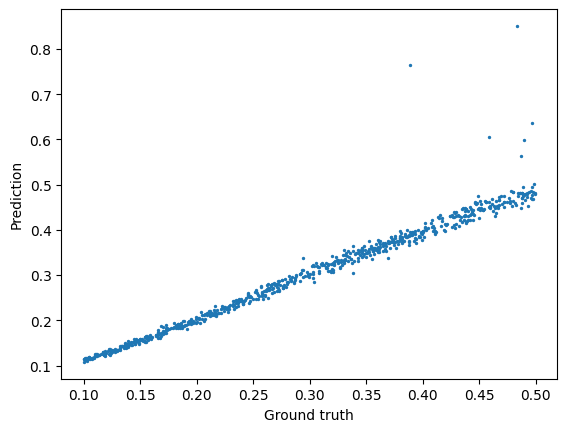

In [26]:
plt.scatter(lbl_simba, yhat_simba, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()